# Import Libary and Environment 

#### In terms of task 2, in order to recommend 10 similar images with the query images, an unsupervised learning method K-means Clustering has been used to implement suggesting functionality:

<b>1. Image Classification:</b> Reuse the ultimate machine learning model CNN to classify the user-query image into one of the six categories.

<b>2. Similary Detection:</b>
- Building a Convolutional Neural Network (CNN) as feature extractor to collect the feature vectors from the images in the whole dataset
- To minimize the dimensionality of the feature vector, as a experiment, we are specify the dimensions into 20. All the image in the dataset will be extracted and append the values into the dataframe. Furthermore, in order to later usage, it will be store as a .csv file in the ./data/recommmend_feature_vector.csv
- Then using the same CNN to extract a feature vector with the query image.
- Finally, appling the K-Means algorithm to cluster reference image's feature vector with those of the images in our dataset. We choose the number of cluster K dynamically using the number of recommending images.

<b>3. Ranking & Recommending the similar image:</b> Once we receive the clusters, we can recommend the images from the cluster that reference images in. To ranking the similarity based on the scores, ultilizing the COSINE similary from the Scikit-learn library marks the top 10 similar images.

<b>Limitation: </b>  Since the k-clustering is the unsupervised algorithm, we can not define similarity metric which atributes (label) that supposing the recommendations is similar to the query image in terms of shape, size, color, etc.

<b> Hence,</b> we are taking the K-means approach as the reference model to compare with our ultimate recommeding models

In [15]:
import numpy as np
import pandas as pd

# import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras.preprocessing import image
from keras.models import Model
import os
from scipy.stats import skew
from joblib import dump, load


from keras.models import Model
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
# from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.image as mpimg
import joblib
path_model_feature_extractor = "feature_extractor_for_all_data"
path_model_clustering = "cluster_model.h5"
path_recommender_full_database = "./data/feature_vectors_recommend_dimension.csv"
path_model_clustering_full = "k-means-clustering_20_dimension.h5"

### Check for the GPU usage and Tensorflow version

In [2]:
import sys
import tensorflow as tf
import cv2

print("Tensorflow version:", tf.__version__)
print(sys.version)
tf.test.is_gpu_available()

Tensorflow version: 2.10.0
3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Define a function to classify the query image from user

In [3]:
from tensorflow.keras.models import load_model
def classify(image_path, classifier_path, return_original=False):
    # Load the pre-trained classifier model
    classifier_model = load_model(classifier_path)
    
    # Preprocess the image
    # Load and preprocess the image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (150,150))
    normalized_image = resized_image.astype('float32') / 255.0
    
    # Expand dimensions to match the input shape expected by the model
    processed_image = tf.expand_dims(normalized_image, axis=0)
    
    # Perform classification
    predictions = classifier_model.predict(processed_image)
    
   # Get the predicted class label
    predicted_class_index = predictions.argmax(axis=1)[0]
    
    # Define a mapping of class indices to labels
    class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    
    # Decode the predicted class label
    predicted_label = class_labels[predicted_class_index]


    return processed_image, predicted_label

### Load the dataset to preprocess and feature extract

In [4]:
df_raw = pd.read_csv("./data/df_clean.csv")

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81335 entries, 0 to 81334
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  81335 non-null  object
 1   Class    81335 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Construct the CNN model as Feature Extractor

#### Parameters for the Feature Extractor 

In [6]:
# Model Parameters
INPUT_DIM = (150, 150, 3)  # RGB - 3 channels images
FEATURE_VEC_DIM = 20 # Specify the number of dimension of the feature vectors

In [7]:
feature_extractor = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
     
         tf.keras.layers.Conv2D(64, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
    
         tf.keras.layers.Conv2D(128, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
    
        # flatten the layer before feeding into the dense layer #
         tf.keras.layers.Flatten(),
        # dense layer together with dropout to prevent overfitting #
         tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal'),
         tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal'),
         tf.keras.layers.Dense(units=32,activation='relu',kernel_initializer='he_normal'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(FEATURE_VEC_DIM),
        # Output layer with one neuron per category
    ])
feature_extractor.compile(optimizer='adam', loss='mse')

In [8]:
feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

#### Saving the feature extractor with params 

In [9]:
feature_extractor.save(path_model_feature_extractor, overwrite=True)

INFO:tensorflow:Assets written to: feature_extractor_for_all_data\assets


INFO:tensorflow:Assets written to: feature_extractor_for_all_data\assets


#### Store all the feature vectors in the recommendations list

In [10]:
recommendations = {'ImgPath': [], 'Class': []}
for j in range(FEATURE_VEC_DIM):
    recommendations[f'x{j}'] = []

#### Preprocessing image data in dataset and Extract features vector 

In [11]:
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Assuming you have initialized feature_extractor and recommend_image_df earlier
with tf.device('GPU:0'):
    # Define batch size and initialize lists to store features and paths
    batch_size = 32
    features = []
    img_paths = []
    img_classes = []

    # Iterate over each row in the DataFrame
    for i, row in tqdm(df_raw.iterrows(), total=len(df_raw), desc='Extracting feature vectors', position=0, leave=True):
        # Load image path and class
        img_path = row['ImgPath']
        img_class = row['Class']
        
        # Load and preprocess the image
        img = cv2.imread(img_path)
        # Perform any necessary preprocessing (e.g., resizing, normalization)
        resized_image = cv2.resize(img, (150, 150))
        normalized_image = resized_image.astype('float32') / 255.0

        # Append preprocessed image and its corresponding path and class
        img_paths.append(img_path)
        img_classes.append(img_class)
        
        # Add image to batch
        features.append(normalized_image)

        # If the batch is full or it's the last iteration, process the batch
        if len(features) == batch_size or i == len(df_raw) - 1:
            # Convert features to numpy array
            batch_features = np.array(features)

            # Extract feature vectors for the batch
            batch_feature_vectors = feature_extractor.predict(batch_features, verbose=0)

            # Flatten and append feature vectors to recommendations
            for j in range(len(batch_feature_vectors)):
                img_path = img_paths[j]
                img_class = img_classes[j]
                feature_vector = batch_feature_vectors[j]

                # Append image path, class, and features to recommendations
                recommendations['ImgPath'].append(img_path)
                recommendations['Class'].append(img_class)
                for k, feature in enumerate(feature_vector.flatten()):
                    recommendations[f'x{k}'].append(feature)

            # Clear lists for the next batch
            features = []
            img_paths = []
            img_classes = []

Extracting feature vectors: 100%|███████████████████████████████████████████████| 81335/81335 [09:12<00:00, 147.25it/s]


### Save the list to the csv file for further usages.

In [12]:
# Convert recommendations to DataFrame
df_full_feature_vectors = pd.DataFrame(recommendations)
df_full_feature_vectors.to_csv(path_recommender_full_database, index=False)

### Contruct a base Kmeans cluster model

In [13]:
from sklearn.cluster import KMeans
clu = KMeans(init='k-means++', n_init='auto')

In [16]:
joblib.dump(clu, path_model_clustering_full)

['k-means-clustering_20_dimension.h5']

In [17]:
fe = tf.keras.models.load_model(path_model_feature_extractor)
clu = joblib.load(path_model_clustering_full)

### Loading the feature vectors

In [18]:
df_rec_feature = pd.read_csv(path_recommender_full_database)

In [19]:
df_rec_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81335 entries, 0 to 81334
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ImgPath  81335 non-null  object 
 1   Class    81335 non-null  object 
 2   x0       81335 non-null  float64
 3   x1       81335 non-null  float64
 4   x2       81335 non-null  float64
 5   x3       81335 non-null  float64
 6   x4       81335 non-null  float64
 7   x5       81335 non-null  float64
 8   x6       81335 non-null  float64
 9   x7       81335 non-null  float64
 10  x8       81335 non-null  float64
 11  x9       81335 non-null  float64
 12  x10      81335 non-null  float64
 13  x11      81335 non-null  float64
 14  x12      81335 non-null  float64
 15  x13      81335 non-null  float64
 16  x14      81335 non-null  float64
 17  x15      81335 non-null  float64
 18  x16      81335 non-null  float64
 19  x17      81335 non-null  float64
 20  x18      81335 non-null  float64
 21  x19      813

#### Taking the image input from user

In [20]:
query_image_path = "./query_image/dresser.jpg"

### Classify the query image and preprocess the input image. Reusing the model from task 1

In [21]:
ref_processed, ref_class = classify(query_image_path, classifier_path="model4.h5", return_original=False)

1/1 [==============================] - 0s 404ms/step


#### Specify the recommendation with feature vectors of the matching class with the category of the input image

In [22]:
recommendations = df_rec_feature[df_rec_feature['Class'] == ref_class]

### Extracting the feature vector of the query image

In [23]:
results = []

# Extract reference image feature vector
ref_processed = np.squeeze(ref_processed)
ref_feature_vector = fe.predict(
    tf.expand_dims(ref_processed, axis=0),
    verbose=0
)
ref_feature_vector = ref_feature_vector.astype(float)
ref_feature_vector = ref_feature_vector.reshape(1, -1)

In [24]:
recommendations_clean = recommendations.drop(['ImgPath', 'Class'], axis=1).values
recommendations_clean.shape

(7612, 20)

#### Setting the number of recommendation and the k-cluster

The K-cluster number will be dynamically changed depend on number recommendation

In [25]:
num_recommendations = 10  # Will be provided by the user in the client code
k = int(np.sqrt(len(recommendations_clean) / num_recommendations))
clu.set_params(n_clusters=k)


KMeans(n_clusters=27)

#### Fit and predict with the K-means clustering

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
# Cluster reference image
clu.fit(recommendations_clean)
# clu.fit(df_rec_feature.drop(['ImgPath', 'Class'], axis=1).values)
ref_cluster = clu.predict(ref_feature_vector)
# ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
# Calculate pairwise distances between the reference cluster centroid and all cluster centroids
pairwise_distances_to_centroids = pairwise_distances(clu.cluster_centers_, ref_feature_vector.reshape(1, -1))

# Find the index of the closest cluster centroid
closest_centroid_index = np.argmin(pairwise_distances_to_centroids)

# Get the indices of data points in the closest cluster
ref_cluster_indices = np.where(clu.labels_ == closest_centroid_index)[0]

### Using the cosine similar to rank the best of 10 matching with query image

In [28]:
recommendations_similar = recommendations.iloc[ref_cluster_indices]

# Calculate cosine similarities
cosine_similarities = cosine_similarity(ref_feature_vector, recommendations_similar.drop(['ImgPath', 'Class'], axis=1))
cosine_similarities = cosine_similarities.flatten()

# Sort and get top recommendations
sorted_indices = np.argsort(-cosine_similarities)
top_indices = sorted_indices[:num_recommendations]
top_recommendations = recommendations_similar.iloc[top_indices]
# Store top indices and their corresponding similarity scores
top_similarity_scores = cosine_similarities[top_indices]

results.append(top_recommendations['ImgPath'].values)

print(results)

[array(['data/Furniture_Data\\dressers\\Transitional\\1585transitional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Transitional\\1840transitional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Farmhouse\\dresser3424234.jpg',
       'data/Furniture_Data\\dressers\\Beach\\5165beach-style-dressers.jpg',
       'data/Furniture_Data\\dressers\\Traditional\\2389traditional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Traditional\\4474traditional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Contemporary\\153contemporary-dressers.jpg',
       'data/Furniture_Data\\dressers\\Traditional\\4060traditional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Traditional\\4657traditional-dressers.jpg',
       'data/Furniture_Data\\dressers\\Rustic\\5906rustic-dressers.jpg'],
      dtype=object)]


In [29]:
top_similarity_scores

array([0.9912202 , 0.99089864, 0.99018844, 0.99012329, 0.98977294,
       0.98965451, 0.98934417, 0.98904982, 0.98892424, 0.98793973])

### Demonstrate the images in the result with similarity score

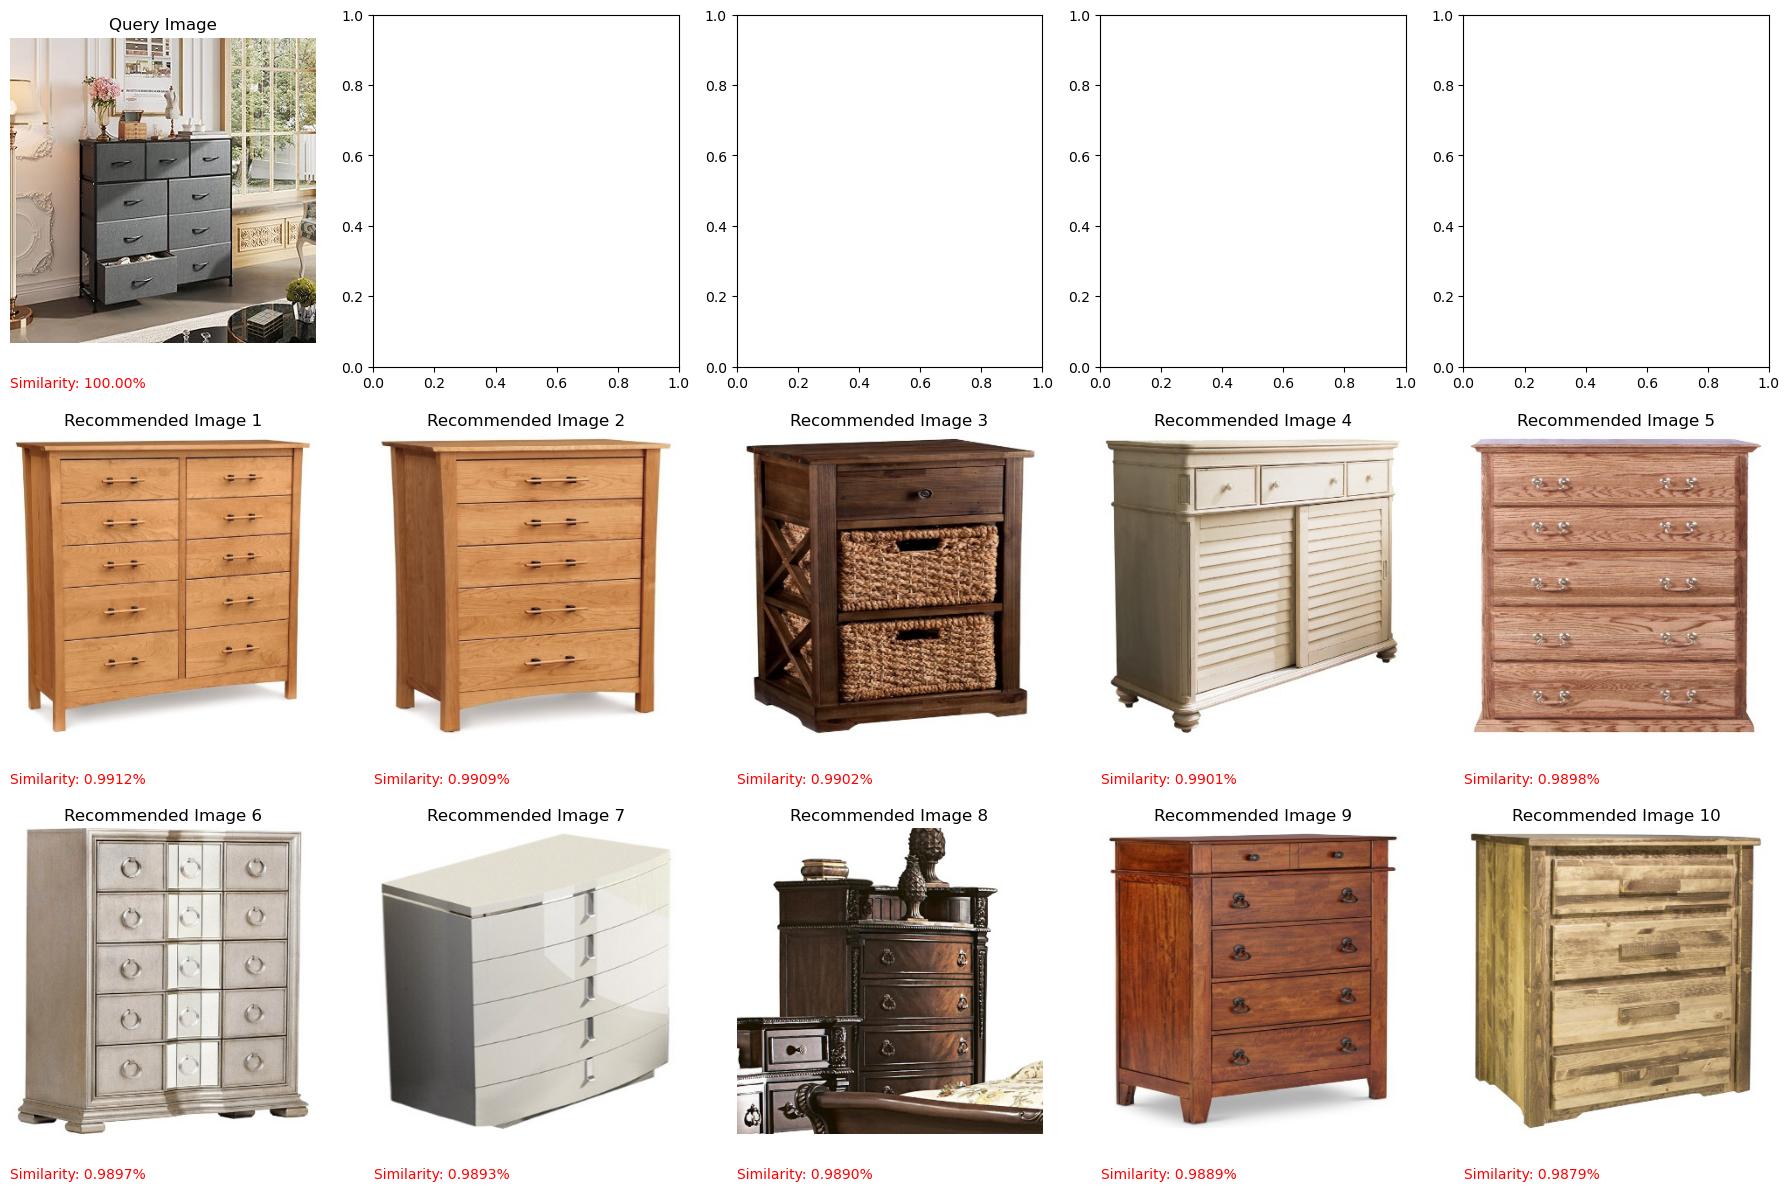

In [30]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming results is the array of image paths you provided, and query_image_path is the path to the query image
import matplotlib.pyplot as plt
from PIL import Image

# Create subplots
fig, ax = plt.subplots(3, 5, figsize=(18, 12))

# Plot the query image
with Image.open(query_image_path) as query_img:
    ax[0, 0].imshow(query_img)
    ax[0, 0].set_title('Query Image', fontsize=12)
    ax[0, 0].axis('off')

# Display the similarity score for the query image
ax[0, 0].text(0, 400, 'Similarity: 100.00%', fontsize=10, color='red')

# Iterate over recommended image paths
for i, (img_path, similarity) in enumerate(zip(top_recommendations['ImgPath'], top_similarity_scores), start=1):
    row = (i - 1) // 5 + 1  # Determine the row for the current image
    col = (i - 1) % 5       # Determine the column for the current image
    
    with Image.open(img_path) as img:
        ax[row, col].imshow(img)
        ax[row, col].set_title(f'Recommended Image {i}', fontsize=12)
        ax[row, col].axis('off')
        ax[row, col].text(0, 400, f'Similarity: {similarity:.4f}%', fontsize=10, color='red')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# # Save the plot
# fig.savefig('images/image.png')